In [1]:
#引入库
from __future__ import print_function, division
import csv
from PIL import Image
import numpy as np
import h5py
import random
import torch.utils.data as data
import argparse
import torch.optim as optim
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
import time
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchvision import transforms
import itertools
import policy
from policy import mixup_data,EarlyStopper

#使用显卡
torch.cuda.is_available()
#显示显卡类型
torch.cuda.get_device_name(0)
torch.cuda.empty_cache()

d:\anaconda\envs\fuck\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据集

In [2]:
import fer2013_dataset as FER2013

In [3]:
batch_size = 128

In [4]:
trainloader=FER2013.traindata(batch_size=batch_size)
PublicTestloader=FER2013.validdata(batch_size=batch_size)
PrivateTestloader=FER2013.testdata(batch_size=batch_size)

In [5]:
import SEResNet
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SEResNet.se_resnet_18().to(device)
best_model=model


In [6]:
# import CBAM_ResNet18
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = CBAM_ResNet18.cbam_resnet18().to(device)
# best_model=model

In [7]:
print(model)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (globalAvgPool): AvgPool2d(kernel_size=56, stride=1, padding=0)
      (fc1): Linear(in_features=64, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=64, bias=True)
      (sigmoid): Sigmoid()
    )
    (1): BasicBlock(
 

In [8]:

early_stopper = EarlyStopper(patience=5, min_delta=0.1)

加载损失函数及优化器

In [9]:
# from transformers import get_cosine_schedule_with_warmup
# warmup_steps = 5
# learning_rate= 0.01
# optimizer = torch.optim.Adam(model .parameters(), lr=learning_rate)  
# scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=40)
# loss_func = nn.CrossEntropyLoss()  

In [10]:
import torch
from torch.optim import lr_scheduler
# import CyclicLRWithRestarts
learning_rate= 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=0.01)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,60], gamma=0.1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4, nesterov=True)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# 创建 CosineAnnealingLR 对象，周期设置为 10，最小学习率设置为 0.01
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)


# scheduler = CyclicLRWithRestarts.CyclicLRWithRestarts(optimizer, 128, len(trainloader.dataset), restart_period=5, t_mult=1.2, policy="cosine")
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=5,T_mult=2)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(trainloader), epochs=120)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# mode='cosineAnnWarm'
# if mode=='cosineAnn':
#     scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0)
# elif mode=='cosineAnnWarm':
#     scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=5,T_mult=1)

# optimizer = optim.AdamW(model.parameters(),lr=1) #一阶动量和二阶动量都用起来，就是 Adam 了——Adaptive + Momentum。
# scheduel = CosineAnnealingWarmRestarts(optimizer,T_0 = 2,T_mult=1,eta_min=0,last_epoch=-1)#T_0就是初始restart的epoch数目，T_mult就是重启之后因子，默认是1。我觉得可以这样理解，每个restart后，T_0 = T_0 * T_mult。当T_mult默认时，


# # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4, nesterov=True)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=3, verbose=True)


In [11]:

loss_func = nn.CrossEntropyLoss()


In [12]:
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)

In [13]:
train_acc = []
valid_acc= []
train_loss_list = []
valid_loss_list = []
lr_log=[]

In [14]:
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()

In [15]:
epoch = 300
model=best_model

In [41]:

for epoch in range(epoch):
    # scheduler.step()
    train_rights = [] 
    train_losses = []  # 初始化一个空列表来存储每个批次的测试损失
    # Validloss_EachEpoch=0 
    # Trainloss_EachEpoch=0
    # Trainacc_EachEpoch=0
    # Validacc_EachEpoch=0
    Trainbar = tqdm(trainloader)
    for index, (data, target) in enumerate(Trainbar):
        Trainbar.set_description("Training")
        model.train()
        data, target = data.cuda(), target.cuda()
        data = data.type(torch.float32)
        target = target.type(torch.float32)
        data, target = Variable(data, requires_grad=True), Variable(target, requires_grad=True)  # 把数据转换成Variable
        
        # print(data)
        # print(target)
        optimizer.zero_grad()  # 优化器梯度初始化为零
        
        # output = model(data)  # 把数据输入网络并得到输出，即进行前向传播
        # target = target.long()    
        # loss = loss_func(output, target)  # 交叉熵损失函数
                # 使用autocast进行自动混合精度
        with autocast():
            # output = model(data)  # 把数据输入网络并得到输出，即进行前向传播
            # target = target.long()    
 
            output = model(data)  # 把数据输入网络并得到输出，即进行前向传播
            # loss = loss_func(output, target)  # 交叉熵损失函数

            random_boolean = random.choice([True, False])
            if random_boolean:
                data, targets_a, targets_b, lam = mixup_data(data, target, alpha=1.0) #mixup
                targets_a = targets_a.long()   
                targets_b = targets_b.long()  
                loss = lam * loss_func(output, targets_a) + (1 - lam) * loss_func(output, targets_b)
            else:
                target = target.long() 
                loss = loss_func(output, target)
        # loss.backward()  # 反向传播梯度
        # optimizer.step()  # 结束一次前传+反传之后，更新参数   
                # 使用梯度缩放器进行反向传播
        
        # 使用梯度缩放器进行梯度更新
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    # scheduler.batch_step()

        right = accuracy(output, target) #一批次的准确率，数量大小是batchsize
        train_rights.append(right) #所有批次的准确率，数量大小是iteration
        train_losses.append(loss.item())  # 将每个批次的测试损失添加到列表中
        
        # if batch_idx % 100 ==0:
        #     print('当前epoch：{} | 迭代iteration[{}/{} ({:.0f}%)]'.format(
        #     epoch, 
        #     batch_idx,
        #     len(trainloader),
        #     100.* batch_idx /len(trainloader)
        #     ))
    scheduler.step()
    # scheduler.step(epoch+index/len(trainloader))
    train_r = (sum([tup[0] for tup in train_rights]),sum([tup[1] for tup in train_rights])) #所有的准确率相加，iteration次的batchsize的大小=epoch的总准确率，epochsize(数据集大小)
    avg_train_loss = sum(train_losses) / len(train_losses)
        
    model.eval()
    val_rights = []
    val_losses = []  # 初始化一个空列表来存储每个批次的测试损失
    Validbar = tqdm(PublicTestloader)
    #with torch.no_grad():
    for data, target in Validbar:
        Validbar.set_description("Validing")
        data, target = data.cuda(), target.cuda()
        data = data.type(torch.float32)
        target = target.type(torch.float32)
        data, target = Variable(data,requires_grad=True), Variable(target,requires_grad=True)  # 计算前要把变量变成Variable形式梯度
 
        with autocast():
            output = model(data)
            target = target.long()
            val_loss = loss_func(output, target)


        # output = model(data)
        right = accuracy(output, target)
        val_rights.append(right)
        # 计算测试损失
        val_losses.append(val_loss.item())  # 将每个批次的测试损失添加到列表中
        

        #准确率计算
        # 计算并存储平均测试损失  
    val_r = (sum([tup[0] for tup in val_rights]),sum([tup[1] for tup in val_rights])) 
    avg_val_loss = sum(val_losses) / len(val_losses)  


    train_r_cpu=train_r[0].cpu().numpy()/train_r[1] #epoch的平均准确率
    val_r_cpu=val_r[0].cpu().numpy()/val_r[1]
    
    # Validloss_EachEpoch=avg_val_loss
    # Trainloss_EachEpoch=avg_train_loss
    # Trainacc_EachEpoch=train_r_cpu
    # Validacc_EachEpoch=val_r_cpu
# 


    print('epoch：{}\t训练损失:{:.6f}\t测试损失:{:.6f}\t训练准确率:{:.2f}%\t测试正确率:{:.2f}%\t学习率:{:.6f}%'.format(
    epoch, 
    avg_train_loss,
    avg_val_loss,
    100.*(train_r_cpu),
    100.*(val_r_cpu),
    optimizer.param_groups[0]['lr']
    ))

    train_acc.append(100.*(train_r_cpu))
    valid_acc.append(100.*(val_r_cpu))
    train_loss_list.append(avg_train_loss)
    valid_loss_list.append(avg_val_loss)
    lr_log.append(optimizer.param_groups[0]['lr'])
    if 100.*(val_r_cpu) == max(valid_acc):
        best_model=model #保存一个准确率最高的结果
        torch.save(model.state_dict(), "log/trainedModel/best.pth")
        print('best_model_saved',100.*(val_r_cpu))
    # scheduler.step(Validloss_EachEpoch/Counter)  # 更新学习率
    # if optimizer.param_groups[0]['lr'] < 0.0001:
    #     optimizer.param_groups[0]['lr'] = 0.0001
    if early_stopper.early_stop(avg_val_loss):             
        break

Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：0	训练损失:2.039371	测试损失:1.790582	训练准确率:23.67%	测试正确率:25.63%	学习率:0.099997%
best_model_saved 25.633881303984396


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：1	训练损失:1.814914	测试损失:1.803333	训练准确率:24.44%	测试正确率:25.24%	学习率:0.099989%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]


epoch：2	训练损失:1.813052	测试损失:1.782534	训练准确率:24.85%	测试正确率:25.49%	学习率:0.099975%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：3	训练损失:1.809144	测试损失:1.768814	训练准确率:24.99%	测试正确率:26.58%	学习率:0.099956%
best_model_saved 26.58122039565339


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：4	训练损失:1.801171	测试损失:1.865076	训练准确率:25.82%	测试正确率:25.69%	学习率:0.099931%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]


epoch：5	训练损失:1.782288	测试损失:1.723251	训练准确率:27.45%	测试正确率:30.43%	学习率:0.099901%
best_model_saved 30.42630259125104


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：6	训练损失:1.749147	测试损失:1.557846	训练准确率:31.31%	测试正确率:41.04%	学习率:0.099866%
best_model_saved 41.042073000835884


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：7	训练损失:1.682191	测试损失:1.465913	训练准确率:37.53%	测试正确率:43.55%	学习率:0.099825%
best_model_saved 43.54973530231262


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：8	训练损失:1.645367	测试损失:1.342593	训练准确率:41.83%	测试正确率:49.26%	学习率:0.099778%
best_model_saved 49.26163276678741


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：9	训练损失:1.598314	测试损失:1.278859	训练准确率:45.04%	测试正确率:51.74%	学习率:0.099726%
best_model_saved 51.74143215380329


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：10	训练损失:1.589475	测试损失:1.344204	训练准确率:47.56%	测试正确率:53.41%	学习率:0.099669%
best_model_saved 53.41320702145445


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：11	训练损失:1.538111	测试损失:1.231109	训练准确率:49.89%	测试正确率:52.72%	学习率:0.099606%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：12	训练损失:1.546956	测试损失:1.312522	训练准确率:50.88%	测试正确率:51.16%	学习率:0.099537%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：13	训练损失:1.551351	测试损失:1.262808	训练准确率:52.02%	测试正确率:56.09%	学习率:0.099464%
best_model_saved 56.08804680969629


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：14	训练损失:1.505347	测试损失:1.283999	训练准确率:52.94%	测试正确率:53.80%	学习率:0.099384%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch：15	训练损失:1.476154	测试损失:1.176762	训练准确率:54.25%	测试正确率:57.45%	学习率:0.099300%
best_model_saved 57.45332961827807


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：16	训练损失:1.482346	测试损失:1.277094	训练准确率:55.08%	测试正确率:56.67%	学习率:0.099210%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：17	训练损失:1.472041	测试损失:1.201613	训练准确率:55.91%	测试正确率:57.23%	学习率:0.099114%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


epoch：18	训练损失:1.437857	测试损失:1.193031	训练准确率:56.69%	测试正确率:57.51%	学习率:0.099014%
best_model_saved 57.50905544719978


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


epoch：19	训练损失:1.527351	测试损失:1.239777	训练准确率:56.49%	测试正确率:56.78%	学习率:0.098907%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：20	训练损失:1.469944	测试损失:1.221131	训练准确率:57.48%	测试正确率:56.31%	学习率:0.098796%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：21	训练损失:1.422972	测试损失:1.136220	训练准确率:58.12%	测试正确率:61.13%	学习率:0.098679%
best_model_saved 61.13123432711062


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：22	训练损失:1.426720	测试损失:1.144751	训练准确率:58.52%	测试正确率:59.54%	学习率:0.098557%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：23	训练损失:1.446015	测试损失:1.083486	训练准确率:58.86%	测试正确率:60.96%	学习率:0.098429%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：24	训练损失:1.406627	测试损失:1.153489	训练准确率:59.24%	测试正确率:59.10%	学习率:0.098296%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：25	训练损失:1.436662	测试损失:1.029753	训练准确率:59.43%	测试正确率:61.94%	学习率:0.098158%
best_model_saved 61.93925884647534


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch：26	训练损失:1.442679	测试损失:1.159196	训练准确率:59.78%	测试正确率:61.08%	学习率:0.098015%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：27	训练损失:1.402712	测试损失:1.066139	训练准确率:60.11%	测试正确率:61.91%	学习率:0.097866%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


epoch：28	训练损失:1.418197	测试损失:1.124236	训练准确率:60.74%	测试正确率:61.91%	学习率:0.097712%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：29	训练损失:1.423328	测试损失:1.057674	训练准确率:60.97%	测试正确率:63.03%	学习率:0.097553%
best_model_saved 63.02591251044859


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：30	训练损失:1.432439	测试损失:1.123751	训练准确率:61.24%	测试正确率:60.80%	学习率:0.097388%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：31	训练损失:1.411961	测试损失:1.073093	训练准确率:61.62%	测试正确率:63.67%	学习率:0.097219%
best_model_saved 63.6667595430482


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：32	训练损失:1.376166	测试损失:1.082438	训练准确率:61.88%	测试正确率:63.69%	学习率:0.097044%
best_model_saved 63.694622457509055


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：33	训练损失:1.388558	测试损失:1.073173	训练准确率:62.13%	测试正确率:63.75%	学习率:0.096864%
best_model_saved 63.75034828643076


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：34	训练损失:1.375888	测试损失:1.074748	训练准确率:61.72%	测试正确率:64.14%	学习率:0.096679%
best_model_saved 64.1404290888827


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：35	训练损失:1.362801	测试损失:1.023376	训练准确率:62.87%	测试正确率:65.14%	学习率:0.096489%
best_model_saved 65.14349400947339


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：36	训练损失:1.365498	测试损失:1.038193	训练准确率:62.98%	测试正确率:60.46%	学习率:0.096294%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：37	训练损失:1.396767	测试损失:1.069785	训练准确率:63.03%	测试正确率:62.13%	学习率:0.096093%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：38	训练损失:1.370334	测试损失:1.046959	训练准确率:63.07%	测试正确率:62.86%	学习率:0.095888%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：39	训练损失:1.351091	测试损失:1.000797	训练准确率:63.52%	测试正确率:63.33%	学习率:0.095677%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：40	训练损失:1.361022	测试损失:1.046775	训练准确率:64.22%	测试正确率:65.09%	学习率:0.095462%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：41	训练损失:1.325695	测试损失:1.024264	训练准确率:63.82%	测试正确率:63.83%	学习率:0.095241%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：42	训练损失:1.360076	测试损失:1.046665	训练准确率:64.29%	测试正确率:65.00%	学习率:0.095016%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：43	训练损失:1.310628	测试损失:1.009660	训练准确率:64.78%	测试正确率:64.45%	学习率:0.094786%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：44	训练损失:1.332749	测试损失:1.006420	训练准确率:64.27%	测试正确率:65.62%	学习率:0.094550%
best_model_saved 65.61716355530788


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]


epoch：45	训练损失:1.374110	测试损失:1.107087	训练准确率:64.84%	测试正确率:63.19%	学习率:0.094310%


Validing: 100%|██████████| 29/29 [00:08<00:00,  3.60it/s]


epoch：46	训练损失:1.377287	测试损失:1.096964	训练准确率:65.45%	测试正确率:60.99%	学习率:0.094065%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.82it/s]


epoch：47	训练损失:1.304231	测试损失:1.027245	训练准确率:65.23%	测试正确率:64.75%	学习率:0.093815%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：48	训练损失:1.330542	测试损失:1.120354	训练准确率:65.28%	测试正确率:63.97%	学习率:0.093561%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch：49	训练损失:1.361429	测试损失:1.114151	训练准确率:65.74%	测试正确率:63.47%	学习率:0.093301%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：50	训练损失:1.349119	测试损失:1.003901	训练准确率:65.77%	测试正确率:65.03%	学习率:0.093037%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：51	训练损失:1.315946	测试损失:0.968690	训练准确率:65.85%	测试正确率:64.73%	学习率:0.092768%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：52	训练损失:1.301197	测试损失:1.076145	训练准确率:66.26%	测试正确率:64.50%	学习率:0.092495%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]


epoch：53	训练损失:1.365695	测试损失:1.064741	训练准确率:66.30%	测试正确率:64.50%	学习率:0.092216%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：54	训练损失:1.362949	测试损失:0.997299	训练准确率:66.44%	测试正确率:65.31%	学习率:0.091934%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：55	训练损失:1.291580	测试损失:1.034148	训练准确率:66.43%	测试正确率:65.20%	学习率:0.091646%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：56	训练损失:1.322534	测试损失:0.988615	训练准确率:66.55%	测试正确率:64.56%	学习率:0.091354%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：57	训练损失:1.274794	测试损失:0.986243	训练准确率:66.94%	测试正确率:66.34%	学习率:0.091057%
best_model_saved 66.34159933129006


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：58	训练损失:1.376634	测试损失:1.111414	训练准确率:67.05%	测试正确率:65.90%	学习率:0.090756%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：59	训练损失:1.383568	测试损失:0.994544	训练准确率:67.36%	测试正确率:65.95%	学习率:0.090451%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch：60	训练损失:1.340694	测试损失:0.969227	训练准确率:67.31%	测试正确率:67.21%	学习率:0.090141%
best_model_saved 67.20534967957649


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


epoch：61	训练损失:1.292914	测试损失:0.976914	训练准确率:67.45%	测试正确率:64.50%	学习率:0.089826%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：62	训练损失:1.353735	测试损失:1.023560	训练准确率:67.32%	测试正确率:63.53%	学习率:0.089508%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：63	训练损失:1.292170	测试损失:1.014054	训练准确率:67.92%	测试正确率:64.89%	学习率:0.089185%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：64	训练损失:1.296934	测试损失:1.004320	训练准确率:68.05%	测试正确率:66.62%	学习率:0.088857%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：65	训练损失:1.259900	测试损失:1.017695	训练准确率:67.94%	测试正确率:66.95%	学习率:0.088526%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：66	训练损失:1.372558	测试损失:0.965330	训练准确率:68.09%	测试正确率:66.45%	学习率:0.088190%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]


epoch：67	训练损失:1.317986	测试损失:0.982287	训练准确率:69.08%	测试正确率:66.12%	学习率:0.087850%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：68	训练损失:1.319071	测试损失:1.041412	训练准确率:68.24%	测试正确率:64.06%	学习率:0.087506%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：69	训练损失:1.342428	测试损失:0.984176	训练准确率:68.67%	测试正确率:67.15%	学习率:0.087157%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：70	训练损失:1.315643	测试损失:1.007951	训练准确率:68.43%	测试正确率:65.67%	学习率:0.086805%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：71	训练损失:1.296494	测试损失:1.026824	训练准确率:69.01%	测试正确率:63.86%	学习率:0.086448%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：72	训练损失:1.307904	测试损失:1.076829	训练准确率:69.08%	测试正确率:66.06%	学习率:0.086088%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：73	训练损失:1.244541	测试损失:1.023300	训练准确率:69.29%	测试正确率:63.92%	学习率:0.085724%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：74	训练损失:1.309123	测试损失:1.028556	训练准确率:69.47%	测试正确率:66.15%	学习率:0.085355%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：75	训练损失:1.302741	测试损失:1.064527	训练准确率:69.17%	测试正确率:65.78%	学习率:0.084983%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]


epoch：76	训练损失:1.293639	测试损失:1.040277	训练准确率:69.63%	测试正确率:65.59%	学习率:0.084607%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：77	训练损失:1.292850	测试损失:0.992577	训练准确率:69.81%	测试正确率:66.04%	学习率:0.084227%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：78	训练损失:1.328430	测试损失:1.012223	训练准确率:70.28%	测试正确率:65.00%	学习率:0.083844%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：79	训练损失:1.330862	测试损失:1.030782	训练准确率:70.26%	测试正确率:64.20%	学习率:0.083457%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：80	训练损失:1.298582	测试损失:1.038824	训练准确率:70.28%	测试正确率:66.04%	学习率:0.083066%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：81	训练损失:1.338559	测试损失:0.966443	训练准确率:70.50%	测试正确率:66.93%	学习率:0.082671%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：82	训练损失:1.261680	测试损失:0.954977	训练准确率:70.61%	测试正确率:66.51%	学习率:0.082273%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：83	训练损失:1.286091	测试损失:0.946385	训练准确率:70.57%	测试正确率:66.34%	学习率:0.081871%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]


epoch：84	训练损失:1.280520	测试损失:1.029605	训练准确率:70.89%	测试正确率:65.12%	学习率:0.081466%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：85	训练损失:1.261086	测试损失:1.021562	训练准确率:71.48%	测试正确率:66.56%	学习率:0.081057%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


epoch：86	训练损失:1.278988	测试损失:1.073046	训练准确率:71.08%	测试正确率:65.92%	学习率:0.080645%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：87	训练损失:1.301948	测试损失:0.973431	训练准确率:70.96%	测试正确率:66.68%	学习率:0.080230%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：88	训练损失:1.255550	测试损失:1.062045	训练准确率:71.17%	测试正确率:65.62%	学习率:0.079811%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：89	训练损失:1.282731	测试损失:0.980671	训练准确率:71.33%	测试正确率:67.79%	学习率:0.079389%
best_model_saved 67.79047088325439


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：90	训练损失:1.207371	测试损失:0.956912	训练准确率:71.68%	测试正确率:67.60%	学习率:0.078964%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：91	训练损失:1.224563	测试损失:1.024290	训练准确率:71.70%	测试正确率:65.39%	学习率:0.078536%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：92	训练损失:1.291367	测试损失:0.992646	训练准确率:71.51%	测试正确率:66.51%	学习率:0.078104%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：93	训练损失:1.247313	测试损失:0.957616	训练准确率:72.51%	测试正确率:67.09%	学习率:0.077670%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：94	训练损失:1.201890	测试损失:0.945019	训练准确率:72.18%	测试正确率:66.98%	学习率:0.077232%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：95	训练损失:1.262963	测试损失:1.024425	训练准确率:72.25%	测试正确率:66.98%	学习率:0.076791%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：96	训练损失:1.262071	测试损失:0.944721	训练准确率:72.32%	测试正确率:66.79%	学习率:0.076348%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.17it/s]


epoch：97	训练损失:1.255715	测试损失:1.036798	训练准确率:72.80%	测试正确率:66.01%	学习率:0.075901%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]


epoch：98	训练损失:1.226531	测试损失:1.017003	训练准确率:72.74%	测试正确率:63.00%	学习率:0.075452%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]


epoch：99	训练损失:1.228371	测试损失:1.062749	训练准确率:72.60%	测试正确率:67.04%	学习率:0.075000%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]


epoch：100	训练损失:1.228214	测试损失:1.027650	训练准确率:73.25%	测试正确率:65.67%	学习率:0.074545%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


epoch：101	训练损失:1.268296	测试损失:1.026018	训练准确率:72.98%	测试正确率:67.18%	学习率:0.074088%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.69it/s]


epoch：102	训练损失:1.208732	测试损失:0.989806	训练准确率:73.68%	测试正确率:67.32%	学习率:0.073628%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.95it/s]


epoch：103	训练损失:1.169489	测试损失:0.970675	训练准确率:73.93%	测试正确率:66.34%	学习率:0.073165%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


epoch：104	训练损失:1.265348	测试损失:1.005012	训练准确率:73.56%	测试正确率:66.59%	学习率:0.072700%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]


epoch：105	训练损失:1.306555	测试损失:1.048852	训练准确率:73.60%	测试正确率:68.24%	学习率:0.072232%
best_model_saved 68.23627751462803


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


epoch：106	训练损失:1.287653	测试损失:0.981278	训练准确率:73.77%	测试正确率:68.04%	学习率:0.071762%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


epoch：107	训练损失:1.259224	测试损失:1.039577	训练准确率:74.45%	测试正确率:65.00%	学习率:0.071289%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.81it/s]


epoch：108	训练损失:1.180493	测试损失:0.961750	训练准确率:74.32%	测试正确率:66.84%	学习率:0.070814%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.94it/s]


epoch：109	训练损失:1.256934	测试损失:0.949115	训练准确率:74.10%	测试正确率:67.51%	学习率:0.070337%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.89it/s]


epoch：110	训练损失:1.207149	测试损失:0.984159	训练准确率:74.59%	测试正确率:68.71%	学习率:0.069857%
best_model_saved 68.70994706046253


Validing: 100%|██████████| 29/29 [00:08<00:00,  3.58it/s]


epoch：111	训练损失:1.178188	测试损失:0.986988	训练准确率:74.95%	测试正确率:67.37%	学习率:0.069376%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：112	训练损失:1.272747	测试损失:0.960828	训练准确率:75.08%	测试正确率:68.88%	学习率:0.068892%
best_model_saved 68.87712454722764


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：113	训练损失:1.249440	测试损失:0.986121	训练准确率:75.10%	测试正确率:67.68%	学习率:0.068406%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：114	训练损失:1.217422	测试损失:1.032796	训练准确率:74.77%	测试正确率:67.32%	学习率:0.067918%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]


epoch：115	训练损失:1.200163	测试损失:0.938734	训练准确率:74.94%	测试正确率:68.15%	学习率:0.067429%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：116	训练损失:1.181053	测试损失:0.987263	训练准确率:75.61%	测试正确率:66.20%	学习率:0.066937%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]


epoch：117	训练损失:1.245897	测试损失:0.988782	训练准确率:76.07%	测试正确率:66.51%	学习率:0.066443%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：118	训练损失:1.221950	测试损失:0.948180	训练准确率:75.57%	测试正确率:67.90%	学习率:0.065948%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：119	训练损失:1.187124	测试损失:0.970287	训练准确率:76.16%	测试正确率:67.96%	学习率:0.065451%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


epoch：120	训练损失:1.191899	测试损失:0.986227	训练准确率:76.07%	测试正确率:67.71%	学习率:0.064952%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：121	训练损失:1.205484	测试损失:0.941446	训练准确率:76.39%	测试正确率:67.79%	学习率:0.064452%


Validing: 100%|██████████| 29/29 [00:08<00:00,  3.34it/s]


epoch：122	训练损失:1.245704	测试损失:0.975823	训练准确率:76.00%	测试正确率:67.85%	学习率:0.063950%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.89it/s]


epoch：123	训练损失:1.184306	测试损失:1.026809	训练准确率:76.75%	测试正确率:63.30%	学习率:0.063446%


Validing: 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


epoch：124	训练损失:1.240366	测试损失:0.957168	训练准确率:76.44%	测试正确率:69.27%	学习率:0.062941%
best_model_saved 69.26720534967957


Validing: 100%|██████████| 29/29 [00:10<00:00,  2.83it/s]


epoch：125	训练损失:1.168639	测试损失:0.947310	训练准确率:76.49%	测试正确率:68.24%	学习率:0.062434%


Validing: 100%|██████████| 29/29 [00:10<00:00,  2.72it/s]


epoch：126	训练损失:1.206827	测试损失:0.956089	训练准确率:77.29%	测试正确率:68.24%	学习率:0.061927%


Validing: 100%|██████████| 29/29 [00:09<00:00,  2.91it/s]


epoch：127	训练损失:1.185008	测试损失:0.946779	训练准确率:77.15%	测试正确率:69.21%	学习率:0.061418%


Validing: 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]


epoch：128	训练损失:1.184148	测试损失:0.989841	训练准确率:77.07%	测试正确率:68.10%	学习率:0.060907%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.71it/s]


epoch：129	训练损失:1.148598	测试损失:0.920700	训练准确率:77.33%	测试正确率:68.65%	学习率:0.060396%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.73it/s]


epoch：130	训练损失:1.166558	测试损失:0.944258	训练准确率:77.97%	测试正确率:68.96%	学习率:0.059883%


Validing: 100%|██████████| 29/29 [00:07<00:00,  3.75it/s]


epoch：131	训练损失:1.205691	测试损失:0.987259	训练准确率:77.63%	测试正确率:66.37%	学习率:0.059369%


Validing: 100%|██████████| 29/29 [00:10<00:00,  2.88it/s]


epoch：132	训练损失:1.151657	测试损失:0.953693	训练准确率:77.71%	测试正确率:67.18%	学习率:0.058854%


Validing: 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


epoch：133	训练损失:1.213294	测试损失:0.964662	训练准确率:78.14%	测试正确率:68.46%	学习率:0.058338%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.06it/s]


epoch：134	训练损失:1.187885	测试损失:0.966384	训练准确率:78.08%	测试正确率:69.32%	学习率:0.057822%
best_model_saved 69.32293117860128


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]


epoch：135	训练损失:1.159623	测试损失:0.939406	训练准确率:78.50%	测试正确率:67.90%	学习率:0.057304%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.14it/s]


epoch：136	训练损失:1.099833	测试损失:0.957505	训练准确率:78.33%	测试正确率:68.51%	学习率:0.056786%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]


epoch：137	训练损失:1.178448	测试损失:1.071969	训练准确率:78.22%	测试正确率:66.26%	学习率:0.056267%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：138	训练损失:1.147738	测试损失:0.947213	训练准确率:78.66%	测试正确率:67.90%	学习率:0.055747%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]


epoch：139	训练损失:1.226434	测试损失:0.961752	训练准确率:78.83%	测试正确率:68.15%	学习率:0.055226%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.12it/s]


epoch：140	训练损失:1.120317	测试损失:0.958545	训练准确率:79.20%	测试正确率:68.10%	学习率:0.054705%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：141	训练损失:1.127400	测试损失:0.913653	训练准确率:79.22%	测试正确率:69.02%	学习率:0.054184%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：142	训练损失:1.174321	测试损失:1.031204	训练准确率:79.10%	测试正确率:68.60%	学习率:0.053662%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]


epoch：143	训练损失:1.100905	测试损失:0.939256	训练准确率:79.36%	测试正确率:67.68%	学习率:0.053140%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：144	训练损失:1.196188	测试损失:1.032214	训练准确率:79.72%	测试正确率:68.57%	学习率:0.052617%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


epoch：145	训练损失:1.205588	测试损失:0.971042	训练准确率:80.23%	测试正确率:67.90%	学习率:0.052094%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：146	训练损失:1.154828	测试损失:0.986609	训练准确率:80.29%	测试正确率:68.01%	学习率:0.051571%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]


epoch：147	训练损失:1.126677	测试损失:0.968919	训练准确率:80.04%	测试正确率:68.43%	学习率:0.051047%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]


epoch：148	训练损失:1.110089	测试损失:0.986811	训练准确率:80.25%	测试正确率:67.71%	学习率:0.050524%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：149	训练损失:1.181129	测试损失:0.978198	训练准确率:80.58%	测试正确率:67.51%	学习率:0.050000%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：150	训练损失:1.094487	测试损失:0.964438	训练准确率:80.12%	测试正确率:67.76%	学习率:0.049476%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


epoch：151	训练损失:1.096241	测试损失:0.967226	训练准确率:80.57%	测试正确率:68.85%	学习率:0.048953%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：152	训练损失:1.121675	测试损失:0.986669	训练准确率:80.88%	测试正确率:67.54%	学习率:0.048429%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]


epoch：153	训练损失:1.156778	测试损失:0.963416	训练准确率:80.70%	测试正确率:67.87%	学习率:0.047906%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]


epoch：154	训练损失:1.127684	测试损失:0.953561	训练准确率:80.62%	测试正确率:68.51%	学习率:0.047383%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.38it/s]


epoch：155	训练损失:1.164333	测试损失:0.999773	训练准确率:80.95%	测试正确率:68.79%	学习率:0.046860%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.41it/s]


epoch：156	训练损失:1.176784	测试损失:0.960334	训练准确率:81.07%	测试正确率:68.46%	学习率:0.046338%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]


epoch：157	训练损失:1.147534	测试损失:1.031347	训练准确率:81.62%	测试正确率:67.65%	学习率:0.045816%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：158	训练损失:1.109634	测试损失:0.956275	训练准确率:81.85%	测试正确率:68.71%	学习率:0.045295%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.42it/s]


epoch：159	训练损失:1.074458	测试损失:0.956113	训练准确率:81.99%	测试正确率:69.82%	学习率:0.044774%
best_model_saved 69.82446363889663


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]


epoch：160	训练损失:1.130499	测试损失:0.975972	训练准确率:81.48%	测试正确率:68.79%	学习率:0.044253%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]


epoch：161	训练损失:1.149477	测试损失:0.978925	训练准确率:82.18%	测试正确率:68.49%	学习率:0.043733%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]


epoch：162	训练损失:1.144046	测试损失:1.010522	训练准确率:82.60%	测试正确率:67.32%	学习率:0.043214%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]


epoch：163	训练损失:1.094466	测试损失:0.981291	训练准确率:82.26%	测试正确率:69.35%	学习率:0.042696%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：164	训练损失:1.086367	测试损失:0.993611	训练准确率:82.60%	测试正确率:67.87%	学习率:0.042178%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]


epoch：165	训练损失:1.007721	测试损失:0.961043	训练准确率:82.96%	测试正确率:68.43%	学习率:0.041662%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.09it/s]


epoch：166	训练损失:1.148187	测试损失:0.944916	训练准确率:82.74%	测试正确率:70.30%	学习率:0.041146%
best_model_saved 70.29813318473113


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：167	训练损失:1.087668	测试损失:0.957784	训练准确率:83.20%	测试正确率:69.41%	学习率:0.040631%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：168	训练损失:1.084860	测试损失:0.956354	训练准确率:82.97%	测试正确率:69.60%	学习率:0.040117%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：169	训练损失:1.118144	测试损失:0.942807	训练准确率:83.13%	测试正确率:69.18%	学习率:0.039604%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：170	训练损失:1.106131	测试损失:0.925887	训练准确率:83.53%	测试正确率:69.24%	学习率:0.039093%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：171	训练损失:1.093084	测试损失:0.928156	训练准确率:83.13%	测试正确率:69.32%	学习率:0.038582%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]


epoch：172	训练损失:1.064820	测试损失:1.035579	训练准确率:83.84%	测试正确率:66.82%	学习率:0.038073%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]


epoch：173	训练损失:1.022632	测试损失:0.982113	训练准确率:83.67%	测试正确率:67.48%	学习率:0.037566%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：174	训练损失:0.993660	测试损失:0.987686	训练准确率:83.92%	测试正确率:68.07%	学习率:0.037059%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]


epoch：175	训练损失:1.064285	测试损失:0.975056	训练准确率:84.20%	测试正确率:68.77%	学习率:0.036554%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


epoch：176	训练损失:0.990753	测试损失:0.919811	训练准确率:84.81%	测试正确率:69.80%	学习率:0.036050%


Validing: 100%|██████████| 29/29 [00:07<00:00,  4.12it/s]


epoch：177	训练损失:1.136886	测试损失:0.951982	训练准确率:84.69%	测试正确率:70.19%	学习率:0.035548%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]


epoch：178	训练损失:1.038256	测试损失:0.941835	训练准确率:84.55%	测试正确率:69.30%	学习率:0.035048%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.17it/s]


epoch：179	训练损失:1.078014	测试损失:0.994837	训练准确率:84.85%	测试正确率:69.24%	学习率:0.034549%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]


epoch：180	训练损失:1.099019	测试损失:0.993597	训练准确率:85.46%	测试正确率:69.60%	学习率:0.034052%


Validing: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]

epoch：181	训练损失:1.062328	测试损失:1.018720	训练准确率:84.99%	测试正确率:67.87%	学习率:0.033557%


In [2]:
# import CBAM_ResNet18
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# best_model = CBAM_ResNet18.cbam_resnet18().to(device)
# best_model.load_state_dict(torch.load('log/trainedModel/SE_ResNet_model2_FER2013_AmdaW_20240411.pth'))
# print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (ca): ChannelAttention(
    (avg_pool): AdaptiveAvgPool2d(output_size=1)
    (max_pool): AdaptiveMaxPool2d(output_size=1)
    (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (relu1): ReLU()
    (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (sa): SpatialAttention(
    (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (sigmoid): Sigmoid()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

Validing: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


精度 0.7029813318473113
损失 0.9415070568693096


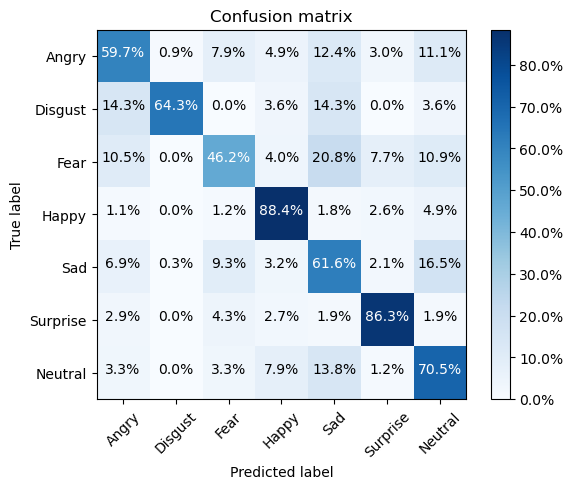

In [42]:
import SEResNet
from utils import result
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_model = SEResNet.se_resnet_18().to(device)
load_model.load_state_dict(torch.load('log/trainedModel/best.pth'))
plt=result(PublicTestloader,load_model)
plt.show()

In [43]:
x1 = range(0, len(train_acc))
x2 = range(0, len(valid_acc))
x3 = range(0, len(train_loss_list))
x4 = range(0, len(valid_loss_list))
x5 = range(0, len(lr_log))
y1 = train_acc
y2 = valid_acc
y3 = train_loss_list
y4 = valid_loss_list
y5 = lr_log

In [45]:
# modelname="SeResNet_model4_adamwWithCycle_20240405"
modelname="SE_ResNet_model2_FER2013_SDB_Cos_mixup_20240415"
loca="log/trainedData/"
csvname=loca+modelname+".csv"
with open(
    f"{csvname}", "w", newline=""
) as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(
        ["Epoch"]
        +
        ["TrainAcc"]
        + 
        ["ValidAcc"]
        +
        ["TrainLoss"]
        + 
        ["ValidLoss"]
        +
        ["LR"]
    )
for index in x1:
    with open(
        f"{csvname}", "a", newline=""
    ) as csvfile:
        writer = csv.writer(csvfile)
        row = [index] + [y1[index]] + [y2[index]] + [y3[index]] + [y4[index]] + [y5[index]]
        writer.writerow(row)

In [46]:
torch.save(load_model.state_dict(), "log/trainedModel/"+modelname+'.pth')

In [ ]:
# torch.save(model, 'SeResNet_model.pth')

d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  
d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


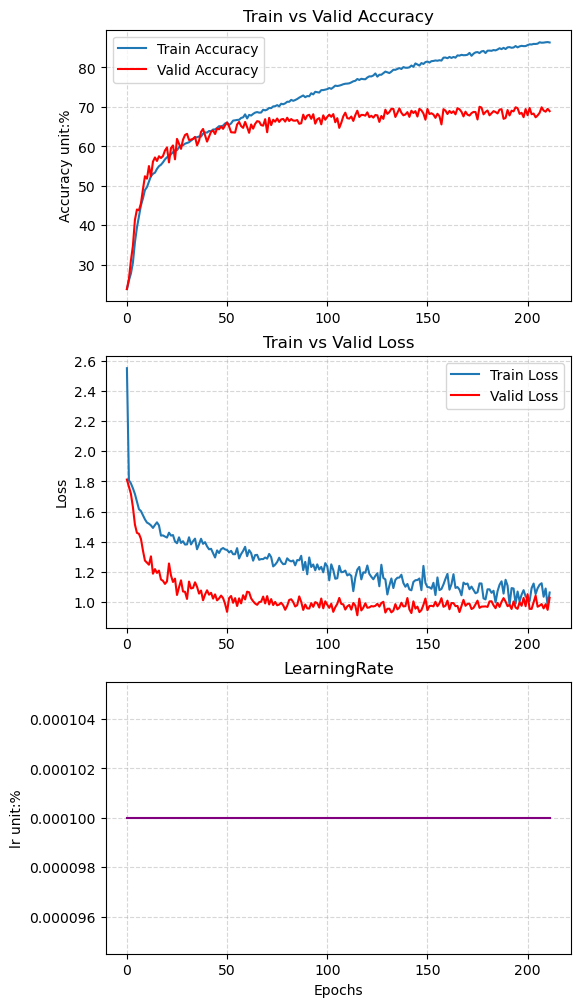

In [29]:
import numpy as np
from matplotlib import pyplot as plt
 
plt.figure(figsize=(6, 12))

# 训练和验证的准确率图像
plt.subplot(3, 1, 1)
plt.plot(x1, y1, label='Train Accuracy')
plt.plot(x2, y2, color='red', label='Valid Accuracy')
plt.title('Train vs Valid Accuracy')
plt.ylabel('Accuracy unit:%')
# my_yTicks1 = np.arange(0, 110, 10)
# plt.yticks(my_yTicks1)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()

# 训练和验证的损失图像
plt.subplot(3, 1, 2)
plt.plot(x3, y3, label='Train Loss')
plt.plot(x4, y4, color='red', label='Valid Loss')
plt.title('Train vs Valid Loss')
plt.ylabel('Loss')
# my_yTicks2 = np.arange(0, 3, 0.5)
# plt.yticks(my_yTicks2)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x5, y5, color='purple', label='lr')
plt.title('LearningRate')
plt.ylabel('lr unit:%')
plt.xlabel('Epochs')
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")

plt.show()

d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


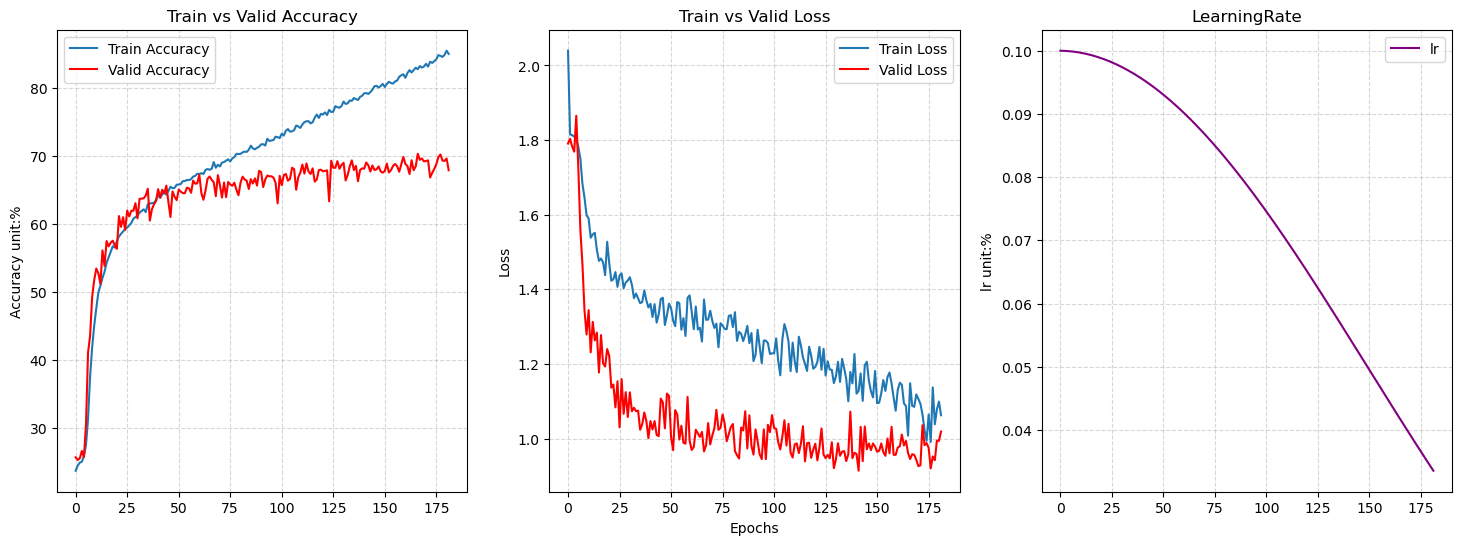

In [44]:
plt.figure(figsize=(18, 6))

# 训练和验证的准确率图像
plt.subplot(1, 3, 1)
plt.plot(x1, y1, label='Train Accuracy')
plt.plot(x2, y2, color='red', label='Valid Accuracy')
plt.title('Train vs Valid Accuracy')
plt.ylabel('Accuracy unit:%')
# my_yTicks1 = np.arange(0, 110, 10)
# plt.yticks(my_yTicks1)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()

# 训练和验证的损失图像
plt.subplot(1, 3, 2)
plt.plot(x3, y3, label='Train Loss')
plt.plot(x4, y4, color='red', label='Valid Loss')
plt.title('Train vs Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# my_yTicks2 = np.arange(0, 3, 0.5)
# plt.yticks(my_yTicks2)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x5, y5, color='purple', label='lr')
plt.title('LearningRate')
plt.ylabel('lr unit:%')
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()

plt.show()

d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  


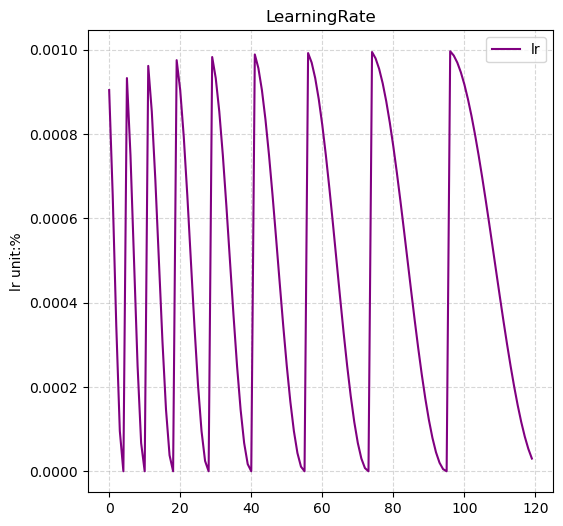

In [443]:
plt.figure(figsize=(6, 6))

# 训练和验证的准确率图像
plt.subplot(1, 1, 1)
plt.plot(x5, y5, color='purple', label='lr')
plt.title('LearningRate')
plt.ylabel('lr unit:%')
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()
plt.show()

d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


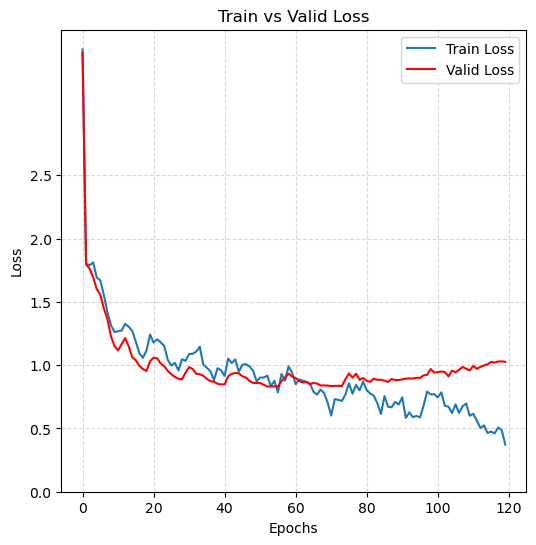

In [444]:
# 训练和验证的损失图像
plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.plot(x3, y3, label='Train Loss')
plt.plot(x4, y4, color='red', label='Valid Loss')
plt.title('Train vs Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
my_yTicks2 = np.arange(0, 3, 0.5)
plt.yticks(my_yTicks2)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()
plt.show()

d:\anaconda\envs\fuck\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


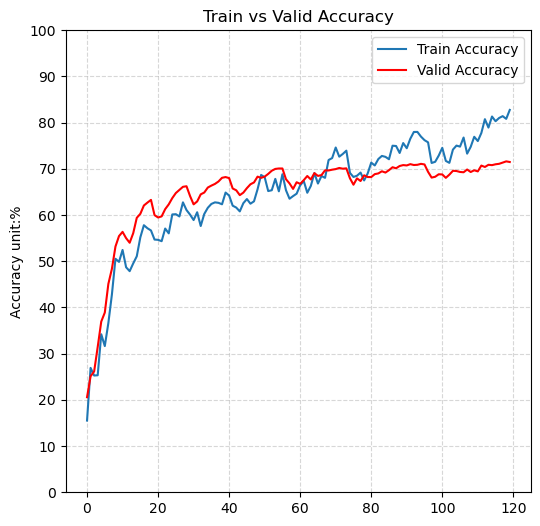

In [445]:
plt.figure(figsize=(6, 6))

# 训练和验证的准确率图像
plt.subplot(1, 1, 1)
plt.plot(x1, y1, label='Train Accuracy')
plt.plot(x2, y2, color='red', label='Valid Accuracy')
plt.title('Train vs Valid Accuracy')
plt.ylabel('Accuracy unit:%')
my_yTicks1 = np.arange(0, 110, 10)
plt.yticks(my_yTicks1)
plt.grid(b=True, linestyle="--", alpha=0.5,axis="both")
plt.legend()
plt.show()

